1]
tf, np, pd
train_test_split(model_selection)
StandardScaler(preprocessing)
confusion_matrix, classification_report(metrics)
sns, plt

2]
count of each class

3]
drop time
x = drop class
y = only class

split

xtrain only has data of 0

scaling using standard scaler
fit_transform on x_train
transform on x_test

frauds in test = sum of y_test

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("creditcard.csv")

print(df['Class'].value_counts())

Class
0    284315
1       492
Name: count, dtype: int64


In [3]:
df = df.drop(['Time'], axis=1)

x = df.drop(['Class'], axis = 1)
y = df['Class']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

x_train = x_train[y_train == 0]

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print("Training shape :", x_train.shape)
print("Testing shape  :", x_test.shape)
print("Frauds in test :", sum(y_test))

Training shape : (227451, 29)
Testing shape  : (56962, 29)
Frauds in test : 98


In [4]:
encoder = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (x_train.shape[1], )),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(16, activation = 'relu')
])    

In [5]:
decoder = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (16, )),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(x_train.shape[1], activation = 'linear')
]) 

autoencoder = tf.keras.models.Sequential([encoder, decoder])
autoencoder.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 16)                  │           4,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 29)                  │           4,541 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,069 (35.43 KB)

 Trainable params: 9,069 (35.43 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])

history = autoencoder.fit(
    x_train, x_train,
    validation_data = (x_test, y_test),
    epochs = 10,
    batch_size = 128,
    shuffle = True
)

Epoch 1/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.5239 - loss: 0.3345 - val_accuracy: 0.0225 - val_loss: 0.8242
Epoch 2/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7019 - loss: 0.1428 - val_accuracy: 0.0345 - val_loss: 0.8882
Epoch 3/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7736 - loss: 0.0999 - val_accuracy: 0.0311 - val_loss: 0.8997
Epoch 4/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8062 - loss: 0.0808 - val_accuracy: 0.0217 - val_loss: 0.9302
Epoch 5/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8204 - loss: 0.0706 - val_accuracy: 0.0296 - val_loss: 0.9316
Epoch 6/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8293 - loss: 0.0639 - val_accuracy: 0.0336 - val_loss: 0.9428
Epoch 7/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8350 - loss: 0.0585 - val_accuracy: 0.0358 - val_loss: 0.9787
Epoch 8/10
1777/1777 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8403 - loss: 0.0536 - 

In [7]:
# In[7]:
# Reconstruct and calculate reconstruction errors
pred = autoencoder.predict(x_test)
recon_error = np.mean((x_test - pred) ** 2, axis=1)

# Combine errors and labels
error_df = pd.DataFrame({'Reconstruction Error': recon_error, 'Class': y_test})

# Split errors by class
normal_error = error_df.query("Class == 0")['Reconstruction Error']
fraud_error  = error_df.query("Class == 1")['Reconstruction Error']

# Print average errors
print("Avg Error (Normal):", normal_error.mean())
print("Avg Error (Fraud):", fraud_error.mean())



1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step  
Avg Error (Normal): 0.041519522487842804
Avg Error (Fraud): 4.69829353928568


In [8]:
threshold = np.percentile(recon_error, 99)
print(threshold)

anomalies = recon_error > threshold
print(anomalies.sum())

0.5231920438932655
570


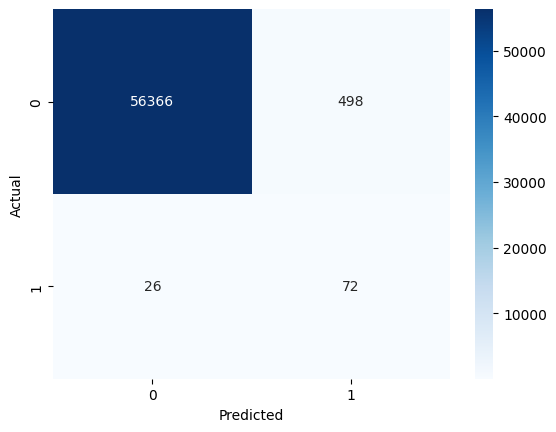

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.13      0.73      0.22        98

    accuracy                           0.99     56962
   macro avg       0.56      0.86      0.61     56962
weighted avg       1.00      0.99      0.99     56962



In [9]:
cm = confusion_matrix(y_test, anomalies)
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(y_test, anomalies))